## 1) Ping-Pong

In [72]:
%%writefile pingpong_1.cpp

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include "time.h"

// function to pass the ball to different reciever
bool ball_was_passed(int reciever, int* order, int iter_num){
    for (int i = 0; i < iter_num; ++i) {
        if (order[i] == reciever) return true;
    }
    return false;
}

int main(int argc, char ** argv){ 
    
    int rank;
    int size;
    int iter_num = 0;

    MPI_Status status;
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    srand(time(0));
    char name = 'a' + rand() % 26;  // random names for processes

    int *order = new int[size];   //opder of processes
    char *names = new char[size]; //names of processes

    int reciever = 0;
    int N = size;   // make N = number of processes

    if (rank == 0){ // start the play
                       
        order[rank] = rank;
        names[rank] = name;
        iter_num ++;
        while(reciever == 0){  // choose different reciever, but not 0 process
            reciever = rand() % size;
        }
        MPI_Ssend(&iter_num, 1, MPI_INT, reciever, 123, MPI_COMM_WORLD);
        MPI_Ssend(order, size, MPI_INT, reciever, 456, MPI_COMM_WORLD);
        MPI_Ssend(names, size, MPI_CHAR, reciever, 789, MPI_COMM_WORLD);
    }
    else {
        MPI_Recv(&iter_num, 1, MPI_INT, MPI_ANY_SOURCE, 123, MPI_COMM_WORLD, &status);
        MPI_Recv(order, size, MPI_INT, MPI_ANY_SOURCE, 456, MPI_COMM_WORLD, &status);
        MPI_Recv(names, size, MPI_CHAR, MPI_ANY_SOURCE, 789, MPI_COMM_WORLD, &status);
        std::cout << "Rank " << rank << " got ball from rank " << status.MPI_SOURCE << std::endl;

        order[iter_num] = rank;
        names[iter_num] = name;
        iter_num ++;

        if (iter_num < N){  // repeat sending N times
            reciever = rand() % size;

            while(ball_was_passed(reciever, order, iter_num)){  // to have different reciever
                reciever = rand() % size;
            }
                
            MPI_Ssend(&iter_num, 1, MPI_INT, reciever, 123, MPI_COMM_WORLD);
            MPI_Ssend(order, iter_num, MPI_INT, reciever, 456, MPI_COMM_WORLD);
            MPI_Ssend(names, iter_num, MPI_CHAR, reciever, 789, MPI_COMM_WORLD);
        }
        
    }
    MPI_Finalize();

    return 0;
}

Overwriting pingpong_1.cpp


In [2]:
!mpic++ pingpong_1.cpp -o pingpong_1

In [8]:
!mpirun --allow-run-as-root -n 6 ./pingpong_1

Rank 2 got ball from rank 0
Rank 4 got ball from rank 2
Rank 3 got ball from rank 4
Rank 5 got ball from rank 3
Rank 1 got ball from rank 5


## 2) Cellular Automata 1-d

In [71]:
%%writefile cell_auto.cpp

#include "mpi.h"
#include <stdio.h>
#include <random>
#include <stdio.h>
#include <iostream>
#include <math.h>

//Design a program in such a way that any kind of rule can be easily inputted into the computations
int rule(int prev, int curr, int next) // rule 110
{
  int sum = prev + curr + next;
  if (prev == 1){
    if (sum == 2) return(1);
    else return (0);
  } else {
      if (sum > 0 ) return(1);
      else return(0);
  }

}

// periodic boundary conditions
void periodic(int * &Batch ,int * &New, int size, int rank, int N){
  int part = N/size;
  for (int i = 0; i < part; i++)
  {
    if (i == 0 && i != part-1 && (i + 1) != part-1)
      New[i] = rule(Batch[part-1], Batch[i], Batch[i+1]);
    else if (i == part-1 && i != 0 && (i - 1) != 0)
      New[i] = rule(Batch[i-1], Batch[i], Batch[0]);
    else if(i == 0 && (i + 1) == part-1)
      New[i] = rule(Batch[part-1], Batch[i], Batch[part-1]);
    else if(i == part-1 && i-1 == 0)
      New[i] = rule(Batch[0], Batch[i], Batch[0]);
    else if(i == 0 && i == part-1)
      New[i] = rule(Batch[i], Batch[i], Batch[i]);
    else
      New[i] = rule(Batch[i-1],Batch[i],Batch[i+1]);
  }
}

// constant boundary conditions
void constant(int * &Batch ,int * &New, int size, int rank, int N){
  int part = N/size;
  for (int i = 0; i < part; i++)
  {
    if (i == 0 && i != part-1 && (i + 1) != part-1)
      New[i] = rule(Batch[part-1], Batch[i], Batch[i+1]);
    else if (i == part-1 && i != 0 && (i - 1) != 0)
      New[i] = rule(Batch[i-1], Batch[i], Batch[0]);
    else if(i == 0 && (i + 1) == part-1)
      New[i] = rule(Batch[part-1], Batch[i], Batch[part-1]);
    else if(i == part-1 && i-1 == 0)
      New[i] = rule(Batch[0], Batch[i], Batch[0]);
    else if(i == 0 && i == part-1)
      New[i] = rule(Batch[i], Batch[i], Batch[i]);
    else
      New[i] = rule(Batch[i-1],Batch[i],Batch[i+1]);
  }
}

void print (int * CellularAutomata, int N){
  for (int i = 0; i < N; i++) printf("%d ", CellularAutomata[i]);
  printf("\n");  
}

int main(int ac, char **av)
{
  int N = 8; 
  int size;
  int rank;
 
  int *CellularAutomata = new int[N];
  int *Batch = new int[N];
  int *New = new int[N];
  int *Result = new int[N];
  
  MPI_Status status;
  MPI_Init(&ac, &av);
  MPI_Comm_rank(MPI_COMM_WORLD, &rank);
  MPI_Comm_size(MPI_COMM_WORLD, &size);

  double start = MPI_Wtime();
  if (rank == 0)
  {
    // initialization
    for (int i = 0; i < N; i++){
      if (i % 3) CellularAutomata[i] = 0;
      else CellularAutomata[i] = 1;
      }
    // end of initialization
   
    //printf("Initialize:\n");
    //print(CellularAutomata, N);

  }
  MPI_Scatter(CellularAutomata, N/size, MPI_INT, Batch, N/size, MPI_INT, 0, MPI_COMM_WORLD);

  MPI_Scatter(Result, N/size, MPI_INT, New, N/size, MPI_INT,  0, MPI_COMM_WORLD);

  periodic(Batch , New, size, rank, N);
 
  MPI_Barrier(MPI_COMM_WORLD);
  MPI_Gather(New, N/size, MPI_INT, Result, N/size, MPI_INT, 0, MPI_COMM_WORLD);

  if (rank == 0)
  {
    //printf("Result:\n");
    //print(Result, N);
  }
 
  MPI_Finalize();
  if (rank ==0){
    double end = MPI_Wtime();
    std::cout << (end-start);
    }
 }

Overwriting cell_auto.cpp


In [65]:
!mpic++ cell_auto.cpp -o cell_auto

In [50]:
!mpirun --allow-run-as-root -n 4 ./cell_auto

Initialize:
1 0 0 1 0 0 1 0 
Result:
1 1 1 1 0 0 1 1 


In [68]:
import matplotlib.pyplot as plt
import numpy as np

In [69]:
exe_time = []
N_processes = np.arange(1,11)
for i in N_processes:
    add = !mpirun --allow-run-as-root -n {i} ./cell_auto
    exe_time.append(float(add[0]))
    print(f"Process {i} with time {add[0]}")

Process 1 with time 0.00170699
Process 2 with time 0.00364131
Process 3 with time 0.00611827
Process 4 with time 0.0045883
Process 5 with time 0.0104772
Process 6 with time 0.0192908
Process 7 with time 0.0190239
Process 8 with time 0.0164648
Process 9 with time 0.0263569
Process 10 with time 0.0266281


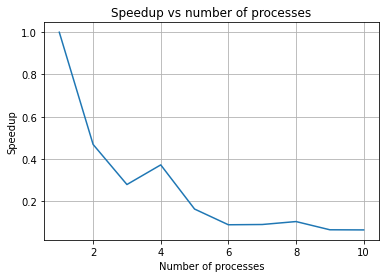

In [70]:
#Plot the speedup vs number of processors 
plt.plot(N_processes,  exe_time[0] / np.array(exe_time))
plt.title('Speedup vs number of processes')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)